In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

# Define your desired path
path = '/content/drive/My Drive/Hack@CSI/20242111'

# Create the directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Change the current working directory to the new path
os.chdir(path)

# Verify the current working directory
print("Current Working Directory:", os.getcwd())


Current Working Directory: /content/drive/My Drive/Hack@CSI/20242111


In [3]:
import numpy as np
import pandas as pd
import sys
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from datasets import import_accelerometer
from sklearn.metrics import roc_auc_score
import seaborn as sns

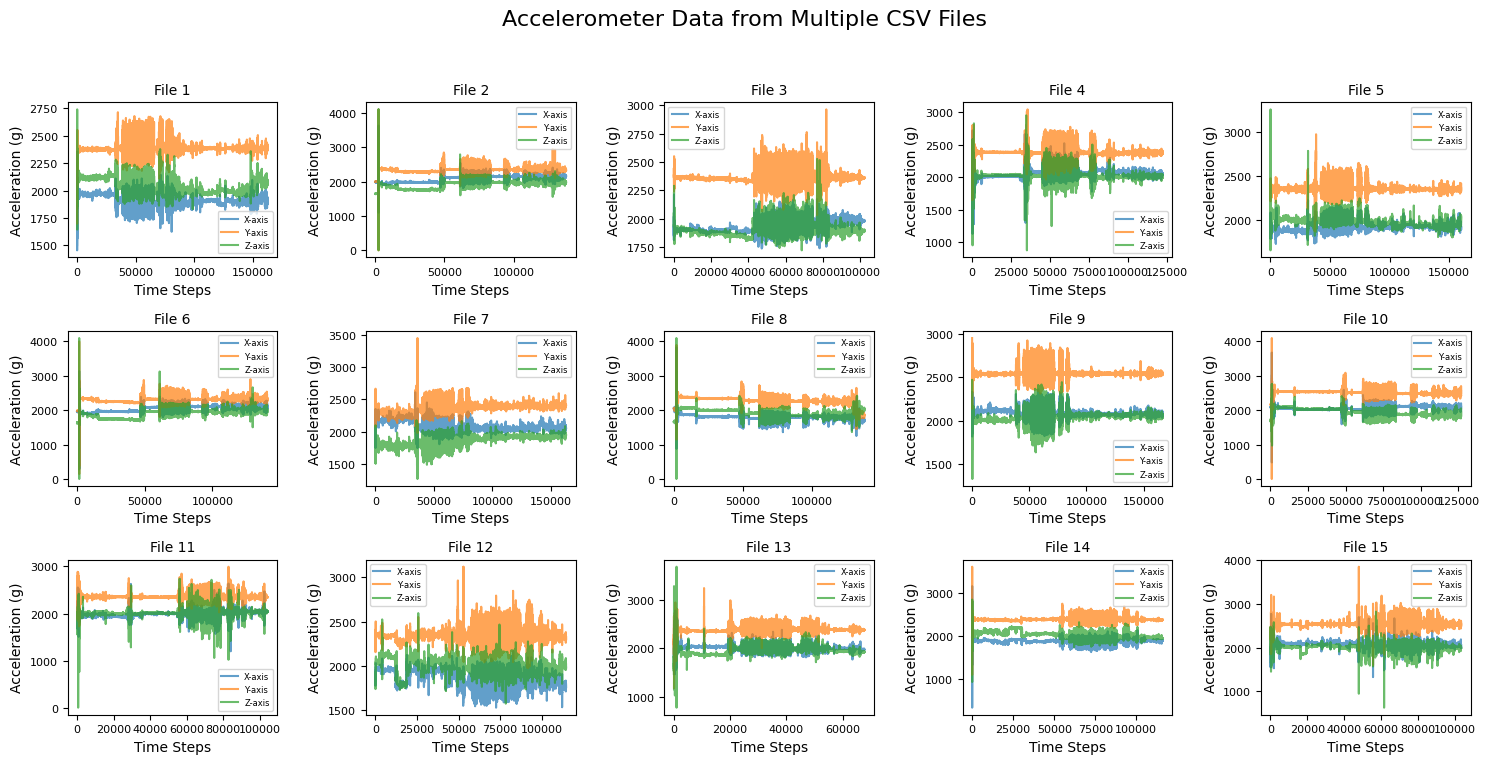

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def import_accelerometer():
    dataframes = []
    for i in range(15):
        # Construct the file path for each CSV
        string = "datasets/Activity Recognition from Single Chest-Mounted Accelerometer/" + str(i+1) + ".csv"
        # Import CSV file and append to the list
        dataframes.append(pd.read_csv(string, header=None))
        # Set column names
        dataframes[i].columns = ["pos", "x", "y", "z", "action"]
        # Drop the 'pos' column
        dataframes[i] = dataframes[i].drop("pos", axis=1)
    return dataframes

# Import the data
dataframes = import_accelerometer()

# Set up a grid of subplots (e.g., 3 rows x 5 columns for 15 plots)
fig, axes = plt.subplots(3, 5, figsize=(15, 8))  # Adjust grid size and figure size as needed
fig.suptitle("Accelerometer Data from Multiple CSV Files", fontsize=16)

# Plot each dataframe's accelerometer data in a subplot
for i, df in enumerate(dataframes):
    ax = axes[i // 5, i % 5]  # Position in the 3x5 grid
    ax.plot(df.index, df["x"], label="X-axis", alpha=0.7)
    ax.plot(df.index, df["y"], label="Y-axis", alpha=0.7)
    ax.plot(df.index, df["z"], label="Z-axis", alpha=0.7)
    ax.set_title(f"File {i+1}", fontsize=10)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Acceleration (mg)")
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=6)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


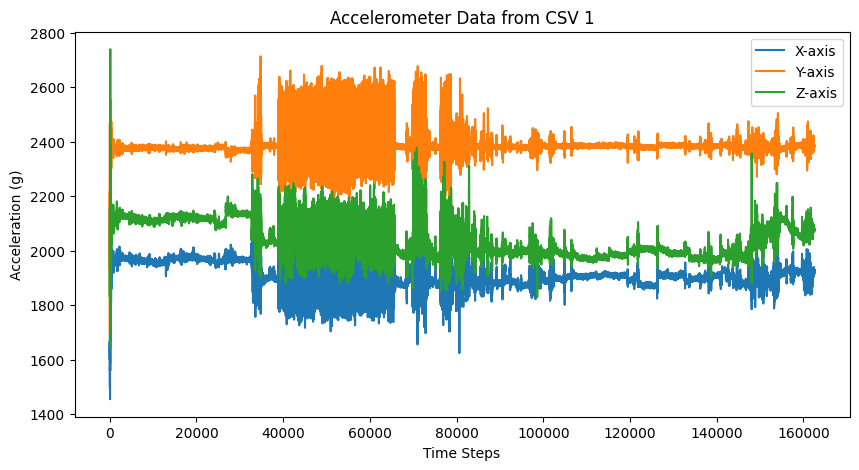

In [ ]:
#Let's zoom on the first acquisition only
plt.figure(figsize=(10, 5))
plt.plot(dataframes[0].index, dataframes[0]["x"], label="X-axis")
plt.plot(dataframes[0].index, dataframes[0]["y"], label="Y-axis")
plt.plot(dataframes[0].index, dataframes[0]["z"], label="Z-axis")
plt.title("Accelerometer Data from CSV 1")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration (mg)")
plt.legend()
plt.show()

# Missing Data Management

In [ ]:
for i, df in enumerate(dataframes):
    missing_data = df.isnull().sum()  # Count of missing values per column
    total_missing = missing_data.sum()  # Total missing values in the dataframe
    if total_missing > 0:
        print(f"CSV {i+1} has missing data:")
        print(missing_data)
    else:
        print(f"CSV {i+1} has no missing data.")


CSV 1 has no missing data.
CSV 2 has no missing data.
CSV 3 has no missing data.
CSV 4 has no missing data.
CSV 5 has no missing data.
CSV 6 has no missing data.
CSV 7 has no missing data.
CSV 8 has no missing data.
CSV 9 has no missing data.
CSV 10 has no missing data.
CSV 11 has no missing data.
CSV 12 has no missing data.
CSV 13 has no missing data.
CSV 14 has no missing data.
CSV 15 has no missing data.


## Example

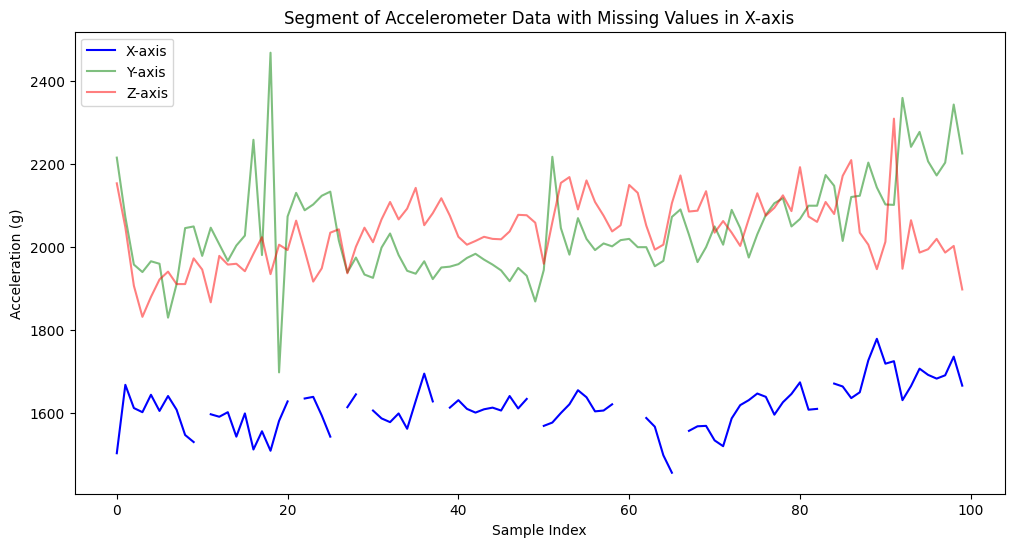

In [ ]:
# Take a small segment of 100 samples from the first signal
segment = dataframes[0].iloc[:100].copy()

# Introduce missing data: randomly set some values in the 'x' column to NaN
missing_percentage = 0.1
num_missing = int(len(segment) * missing_percentage)

# Randomly select indices to set as NaN
missing_indices = np.random.choice(segment.index, num_missing, replace=False)
segment.loc[missing_indices, 'x'] = np.nan

# Plot the segment to visualize the gap in 'x' due to missing data
plt.figure(figsize=(12, 6))
plt.plot(segment.index, segment['x'], label="X-axis", color='blue')
plt.plot(segment.index, segment['y'], label="Y-axis", color='green', alpha=0.5)
plt.plot(segment.index, segment['z'], label="Z-axis", color='red', alpha=0.5)
plt.title("Segment of Accelerometer Data with Missing Values in X-axis")
plt.xlabel("Sample Index")
plt.ylabel("Acceleration (mg)")
plt.legend()
plt.show()


### Fill-out missing data

<ipython-input-35-7b323470ab6d>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  segment_ffill = segment['x'].fillna(method='ffill')


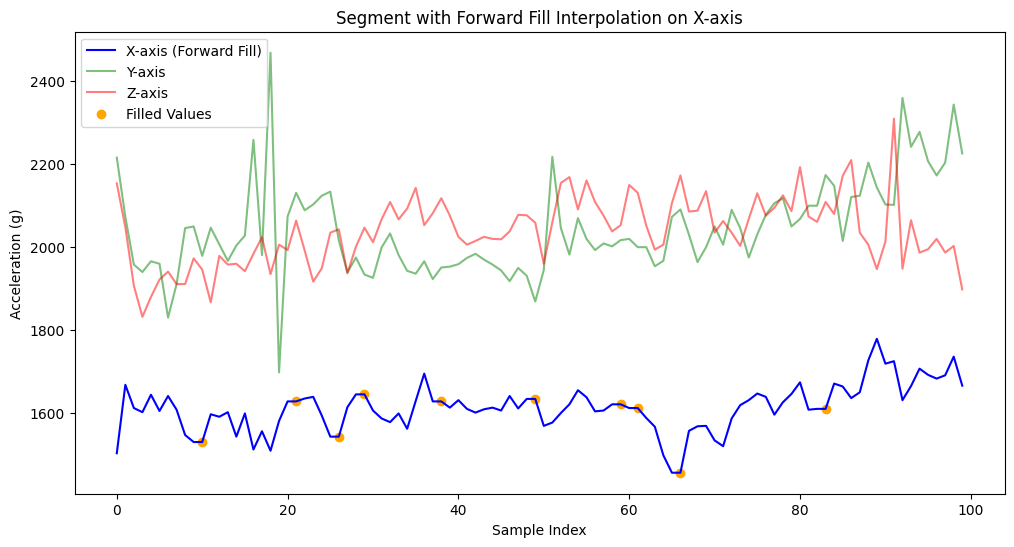

In [ ]:
segment_ffill = segment['x'].fillna(method='ffill') #bfill,linear for Backward and Linear Interpolation
plt.figure(figsize=(12, 6))
plt.plot(segment.index, segment_ffill, label="X-axis (Forward Fill)", color='blue')
plt.plot(segment.index, segment['y'], label="Y-axis", color='green', alpha=0.5)
plt.plot(segment.index, segment['z'], label="Z-axis", color='red', alpha=0.5)
plt.scatter(missing_indices, segment_ffill[missing_indices], color='orange', label="Filled Values", marker='o')
plt.title("Segment with Forward Fill Interpolation on X-axis")
plt.xlabel("Sample Index")
plt.ylabel("Acceleration (mg)")
plt.legend()
plt.show()

# Preprocessing

## Noise filtering

In [5]:
from scipy.signal import butter, filtfilt

In [7]:
fs = 50  # Hz

# Define the cutoff frequency for the initial low-pass filter (20 Hz)
#Human walking frequencies typically fall in the range of 0.5 to 3 Hz.
#Faster activities, like running or going up and down stairs, might extend up to around 5 Hz.
initial_cutoff = 20  # Hz

def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Apply a 20 Hz low-pass filter to all signals (x, y, z)
df['x_filtered'] = low_pass_filter(df['x'], initial_cutoff, fs)
df['y_filtered'] = low_pass_filter(df['y'], initial_cutoff, fs)
df['z_filtered'] = low_pass_filter(df['z'], initial_cutoff, fs)


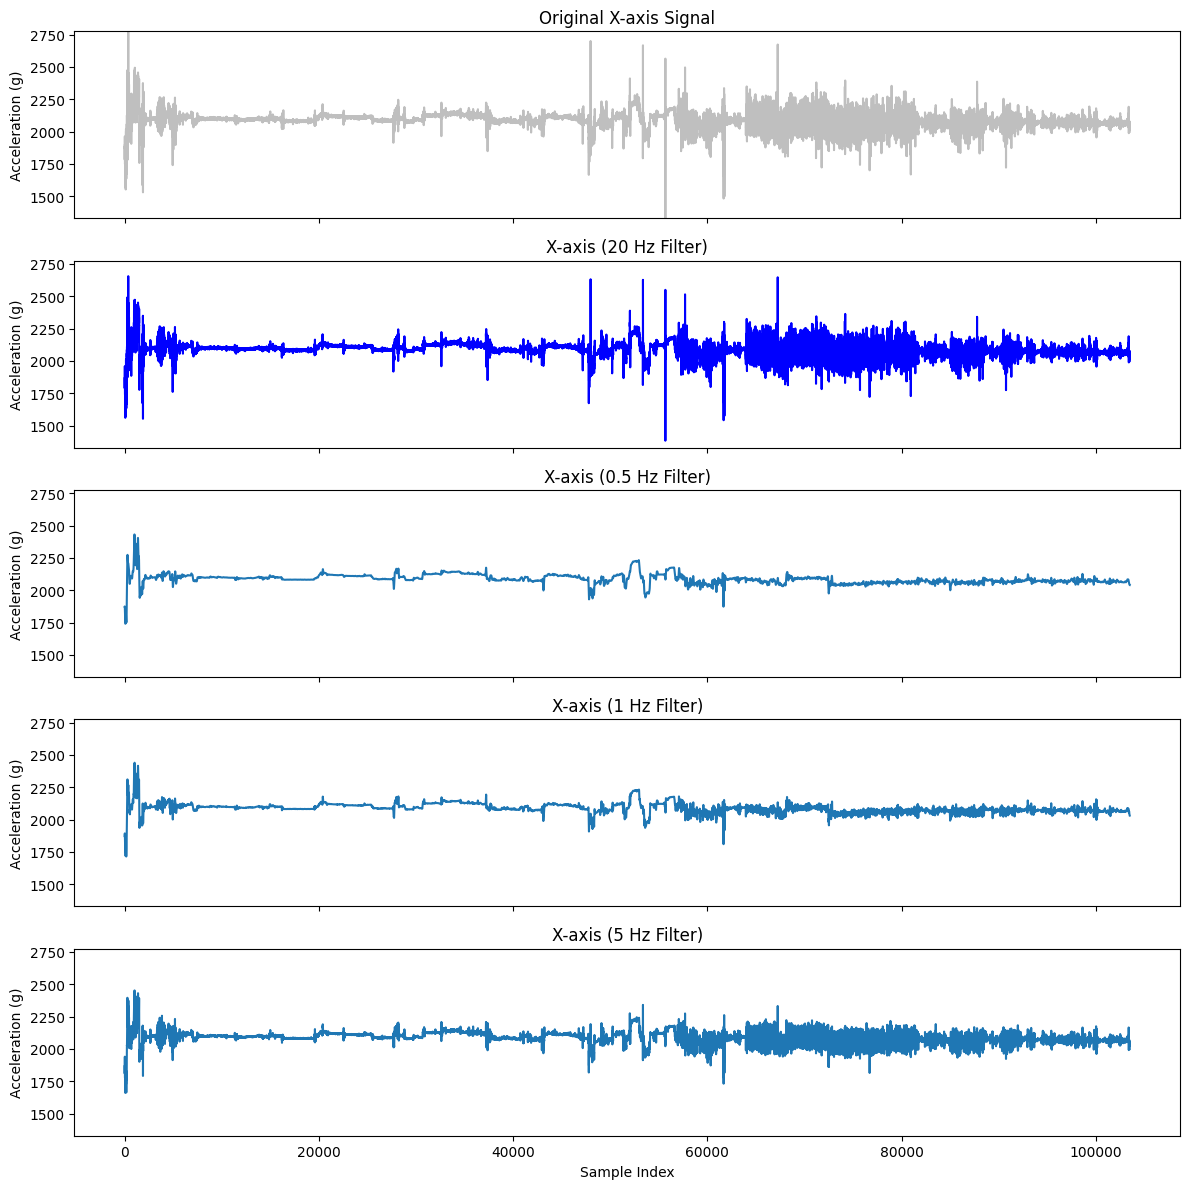

In [9]:
# Define additional cutoff frequencies for comparison
cutoff_frequencies = [0.5, 1, 5]  # Hz

# Determine y-axis limits based on the original signal
y_min, y_max = df['x'].min(), df['x'].max()

# Set up subplots: one row per filter applied
num_plots = len(cutoff_frequencies) + 2
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 12), sharex=True)

# Plot the original 'x' signal
axes[0].plot(df.index, df['x'], color='gray', alpha=0.5)
axes[0].set_title("Original X-axis Signal")
axes[0].set_ylabel("Acceleration (g)")
axes[0].set_ylim(y_min, y_max)  # Fix y-axis

# Plot the 20 Hz filtered signal as the base reference
axes[1].plot(df.index, df['x_filtered'], color='blue')
axes[1].set_title("X-axis (20 Hz Filter)")
axes[1].set_ylabel("Acceleration (g)")
axes[1].set_ylim(y_min, y_max)  # Fix y-axis

# Apply and plot additional low-pass filtered versions for each cutoff frequency
for i, cutoff in enumerate(cutoff_frequencies):
    filtered_signal = low_pass_filter(df['x'], cutoff, fs)
    axes[i + 2].plot(df.index, filtered_signal, label=f"X-axis ({cutoff} Hz Filter)")
    axes[i + 2].set_title(f"X-axis ({cutoff} Hz Filter)")
    axes[i + 2].set_ylabel("Acceleration (mg)")
    axes[i + 2].set_ylim(y_min, y_max)  # Fix y-axis

# Final layout adjustments
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


## Normalization / Standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select the filtered columns for normalization
filtered_features = df[['x_filtered', 'y_filtered', 'z_filtered']]

# Initialize MinMaxScaler with range 0 to 1
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the filtered features
filtered_features_normalized = scaler_minmax.fit_transform(filtered_features)

# Replace the original filtered columns with normalized data in the dataframe
df[['x_filtered', 'y_filtered', 'z_filtered']] = filtered_features_normalized

# Output the normalized filtered data for verification
print(df[['x_filtered', 'y_filtered', 'z_filtered']].head())


   x_filtered  y_filtered  z_filtered
0    0.029568    0.407605    0.710638
1    0.136740    0.219117    0.506807
2    0.187872    0.103102    0.352646
3    0.186289    0.063899    0.283871
4    0.174756    0.048038    0.296484


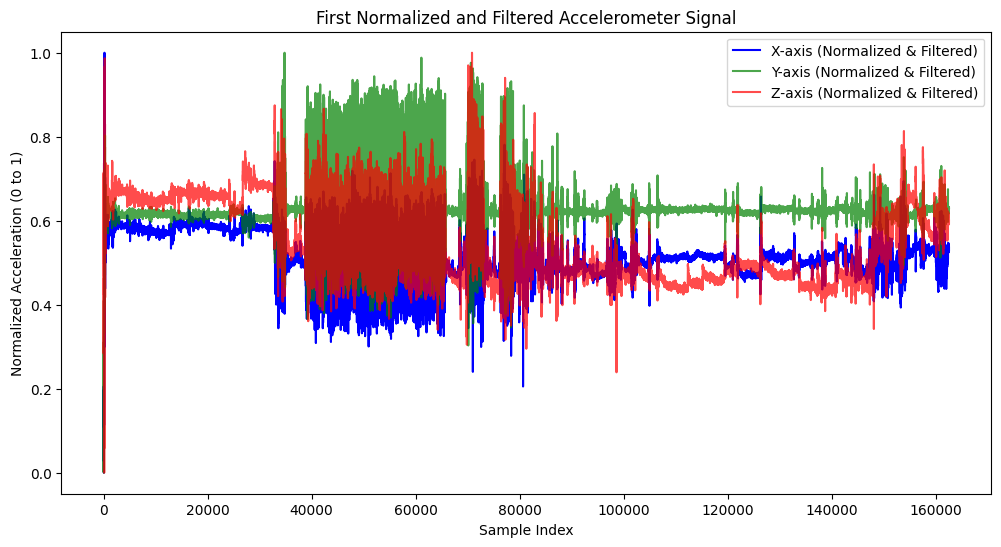

In [ ]:
plt.figure(figsize=(12, 6))

# Plot normalized filtered signals for x, y, and z axes
plt.plot(df.index, df['x_filtered'], label="X-axis (Normalized & Filtered)", color='blue')
plt.plot(df.index, df['y_filtered'], label="Y-axis (Normalized & Filtered)", color='green', alpha=0.7)
plt.plot(df.index, df['z_filtered'], label="Z-axis (Normalized & Filtered)", color='red', alpha=0.7)

# Add labels and legend
plt.title("First Normalized and Filtered Accelerometer Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Acceleration (0 to 1)")
plt.legend()
plt.show()